# Domain-Specialized Text-Guided Image Editing: Improving Edit Accuracy via Targeted Diffusion Fine-Tuning (Fashion Domain)

##CS5787 - Deep Learning @ Cornell Tech

Authors:
*   Sona Krishnan (sk3449)
*   Vishali Vallioor (vv266)
*   David Thai (dt573)

## Code Structure
1.   Imports and Background
2.   Data Preparation
3.   Model Baseline
4.   Fine-Tuning
5.   Evaluation

This code goes through our code structure and background. Make sure to run all the necessary imports. An important note is that you must be in a GPU environment, like Google Colab GPU T4 100 (which is what we ran this on).

# 1. Imports and Background

In [ ]:
# Run this cell for imports and necessary installs

import os
import json
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
import PIL
from PIL import Image
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF
from tqdm import tqdm
from PIL import Image
import gc
from diffusers import StableDiffusionInstructPix2PixPipeline, DDPMScheduler
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision.transforms.functional import to_pil_image
from torch.optim import AdamW
from tqdm.auto import tqdm
import pandas as pd
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import random

# models and dataset
from datasets import load_dataset
from diffusers import StableDiffusionInstructPix2PixPipeline, DPMSolverMultistepScheduler
from transformers import CLIPProcessor, CLIPModel
from datasets import load_dataset

# cloning pix2pix, getting it in

!git clone https://github.com/huggingface/diffusers

%cd examples/instruct_pix2pix
!pip install -r requirements.txt

# from pix2pix hf website

import torch, requests, PIL
from diffusers import StableDiffusionInstructPix2PixPipeline, EulerAncestralDiscreteScheduler
from accelerate.utils import write_basic_config
write_basic_config()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/518 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/569 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


  0%|          | 0/100 [00:00<?, ?it/s]

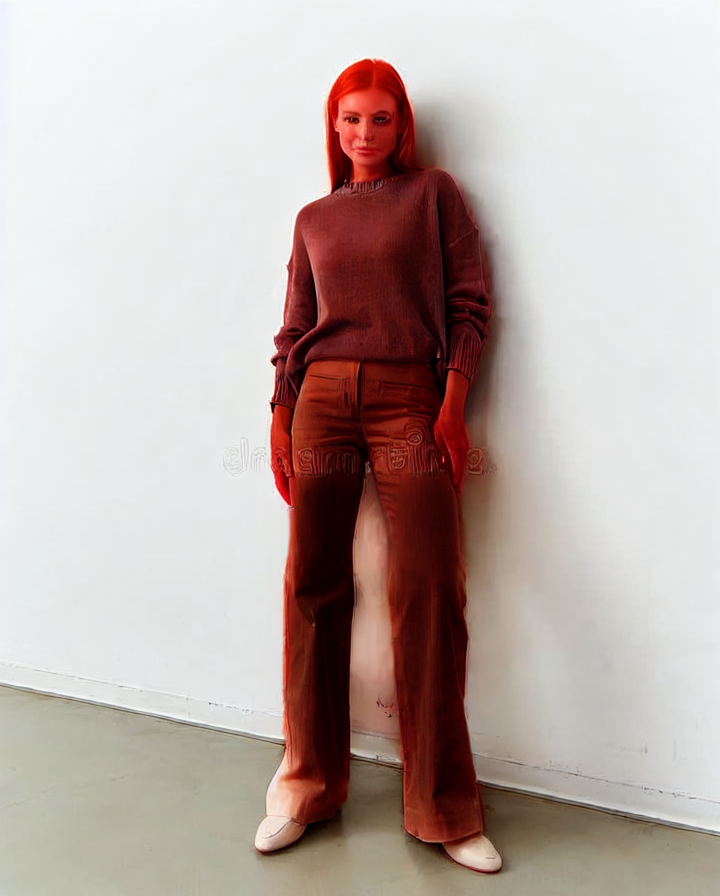

In [ ]:
model_id = "timbrooks/instruct-pix2pix"
pipe = StableDiffusionInstructPix2PixPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    safety_checker=None,
)
pipe.to("cuda")

pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

url = "https://thumbs.dreamstime.com/b/fashion-model-poses-elegantly-modern-studio-showcasing-contemporary-style-confident-female-model-stands-confidently-against-379352737.jpg"

def download_image(url):
    image = PIL.Image.open(requests.get(url, stream=True).raw)
    image = PIL.ImageOps.exif_transpose(image)
    return image.convert("RGB")

image = download_image(url)

prompt = "make her hair red"

images = pipe(
    prompt=prompt,
    image=image,
    num_inference_steps=100,
    guidance_scale=12,
    image_guidance_scale=2.0,
).images

images[0]

  0%|          | 0/100 [00:00<?, ?it/s]

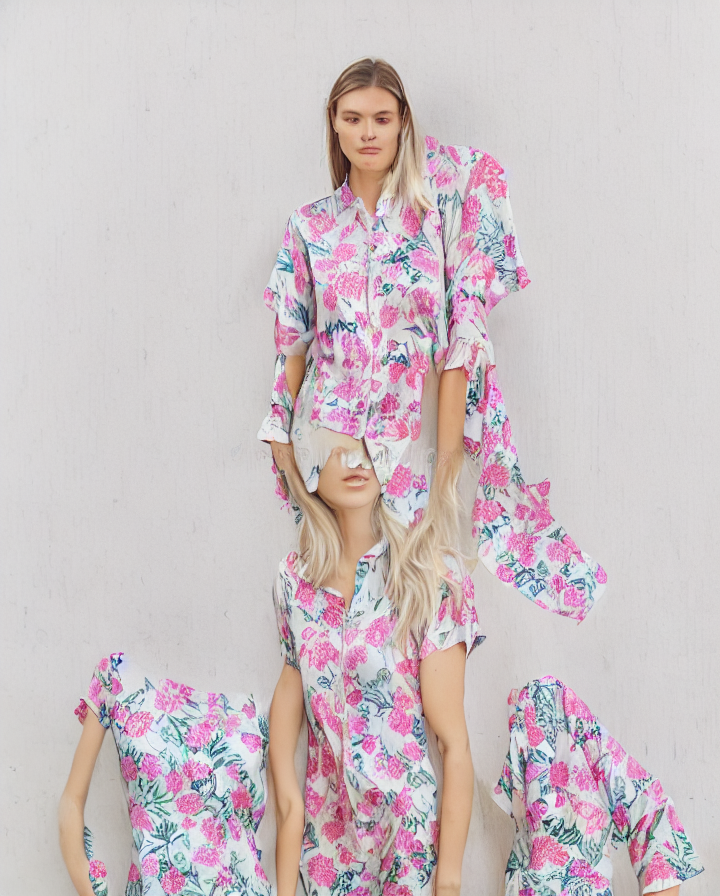

In [ ]:
url = "https://thumbs.dreamstime.com/b/fashion-model-poses-elegantly-modern-studio-showcasing-contemporary-style-confident-female-model-stands-confidently-against-379352737.jpg"

def download_image(url):
    image = PIL.Image.open(requests.get(url, stream=True).raw)
    image = PIL.ImageOps.exif_transpose(image)
    return image.convert("RGB")

image = download_image(url)

prompt = "give her shirt a floral pattern"

images = pipe(
    prompt=prompt,
    image=image,
    num_inference_steps=100,
    guidance_scale=12,
    image_guidance_scale=2.0,
).images

images[0]

# 2. Data Preparation

In the next following lines, we load the fashionpedia/deep fashion dataset we will be using for training. However, the important thing to note is that the DeepFashion dataset is used for training but the FashionPedia is used for validation at the end.

## 2.1 Load FashionPedia Dataset

In [ ]:
#Loading fashionpedia
dataset_fashionpedia = load_dataset("detection-datasets/fashionpedia", split="train", streaming=True)
fashionpedia_samples = list(dataset_fashionpedia.take(100)) #just load 100 for now to see if possible
print(fashionpedia_samples[0]['image'])


clip_model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to("cuda")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

README.md: 0.00B [00:00, ?B/s]

dataset_infos.json: 0.00B [00:00, ?B/s]

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=682x1024 at 0x7914D17502F0>


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

# 2.2 DeepFashion2 Dataset

Now loading in the deep fashion 2 dataset.

In [ ]:
#load deepfashion2
dataset = load_dataset("SaffalPoosh/deepFashion-with-masks")

print(dataset)
print(dataset["train"].features)

sample = dataset["train"][0]
print(sample.keys())


README.md:   0%|          | 0.00/836 [00:00<?, ?B/s]

data/train-00000-of-00004-ed3909a24b468f(…):   0%|          | 0.00/363M [00:00<?, ?B/s]

data/train-00001-of-00004-e2bb46ac3213d7(…):   0%|          | 0.00/364M [00:00<?, ?B/s]

data/train-00002-of-00004-f11f7b29a225c1(…):   0%|          | 0.00/361M [00:00<?, ?B/s]

data/train-00003-of-00004-e6de6e7287b28c(…):   0%|          | 0.00/361M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/40658 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['images', 'gender', 'pose', 'cloth_type', 'pid', 'caption', 'mask', 'mask_overlay'],
        num_rows: 40658
    })
})
{'images': Image(mode=None, decode=True), 'gender': Value('string'), 'pose': Value('string'), 'cloth_type': Value('string'), 'pid': Value('string'), 'caption': Value('string'), 'mask': Image(mode=None, decode=True), 'mask_overlay': Image(mode=None, decode=True)}
dict_keys(['images', 'gender', 'pose', 'cloth_type', 'pid', 'caption', 'mask', 'mask_overlay'])


# 2.3 Generating Triplets for fine-tune the model with (conditioned image, text, output image)

Now the next following blocks of code involves generating the triplets.

In [ ]:
by_pid = defaultdict(list)
for i in range(len(dataset["train"])):
  by_pid[dataset["train"][i]["pid"]].append(i)

multi_outfit = {k: v for k, v in by_pid.items() if len(v) >= 2}
print(f"Total unique people: {len(by_pid)}")
print(f"People with 2+ images: {len(multi_outfit)}")
print(f"Potential pairs: {sum(len(v) for v in multi_outfit.values())}")

Total unique people: 7557
People with 2+ images: 6900
Potential pairs: 40001


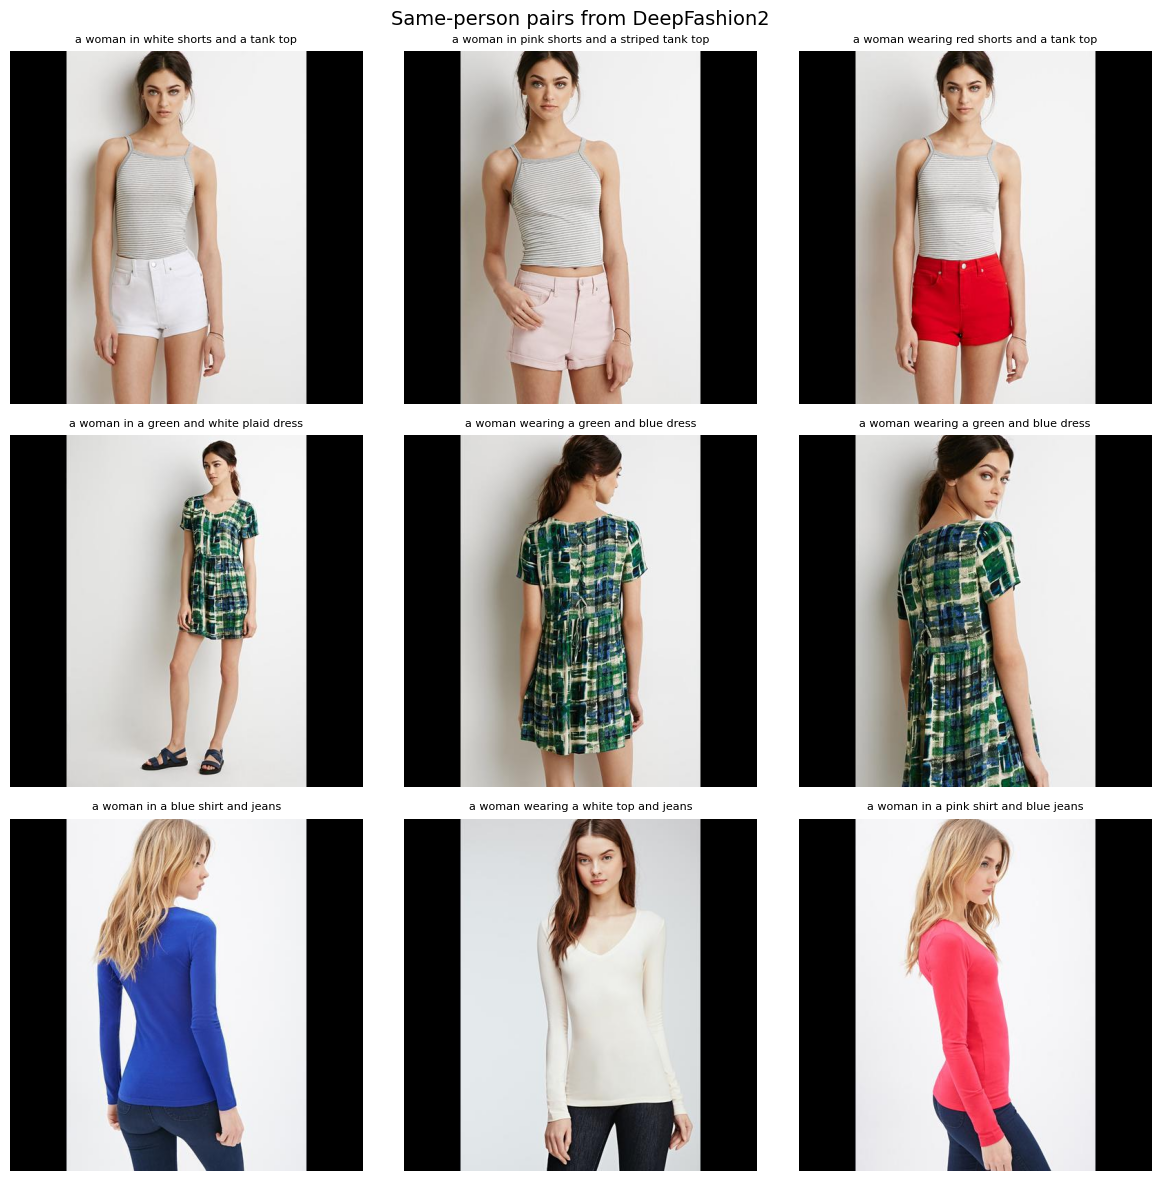

In [ ]:
multi_outfit_pids = [pid for pid, indices in by_pid.items() if len(indices) >= 3]

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
for row, pid in enumerate(multi_outfit_pids[:3]):
  indices = by_pid[pid][:3]
  for col, idx in enumerate(indices):
    sample = dataset["train"][idx]
    axes[row, col].imshow(sample["images"])
    axes[row, col].set_title(sample["caption"], fontsize=8)
    axes[row, col].axis("off")

plt.suptitle("same-person pairs from DeepFashion2", fontsize=14)
plt.tight_layout()
plt.show()


# 2.4 Generating Instructions

In [ ]:
def generate_instruction(caption1, caption2):
  part2 = caption2.lower().split("in ")[-1] if "in " in caption2.lower() else caption2.lower()
  return f"change to {part2}"

MAX_TRIPLETS = 8000

triplets = []
for pid, indices in tqdm(by_pid.items(), desc="Building triplets"):
  if len(indices) < 2:
      continue

  for i in range(len(indices)):
      for j in range(len(indices)):
          if i == j:
              continue

          triplets.append({
                  "src_idx": indices[i],
                  "tgt_idx": indices[j],
              })

          if len(triplets) >= MAX_TRIPLETS:
              break
      if len(triplets) >= MAX_TRIPLETS:
          break
  if len(triplets) >= MAX_TRIPLETS:
      break

print(f"Total triplets: {len(triplets)}")
print(f"Sample: {triplets[0]}")


Building triplets:   0%|          | 17/7557 [00:00<00:01, 4432.07it/s]

Total triplets: 8000
Sample: {'src_idx': 0, 'tgt_idx': 11800}


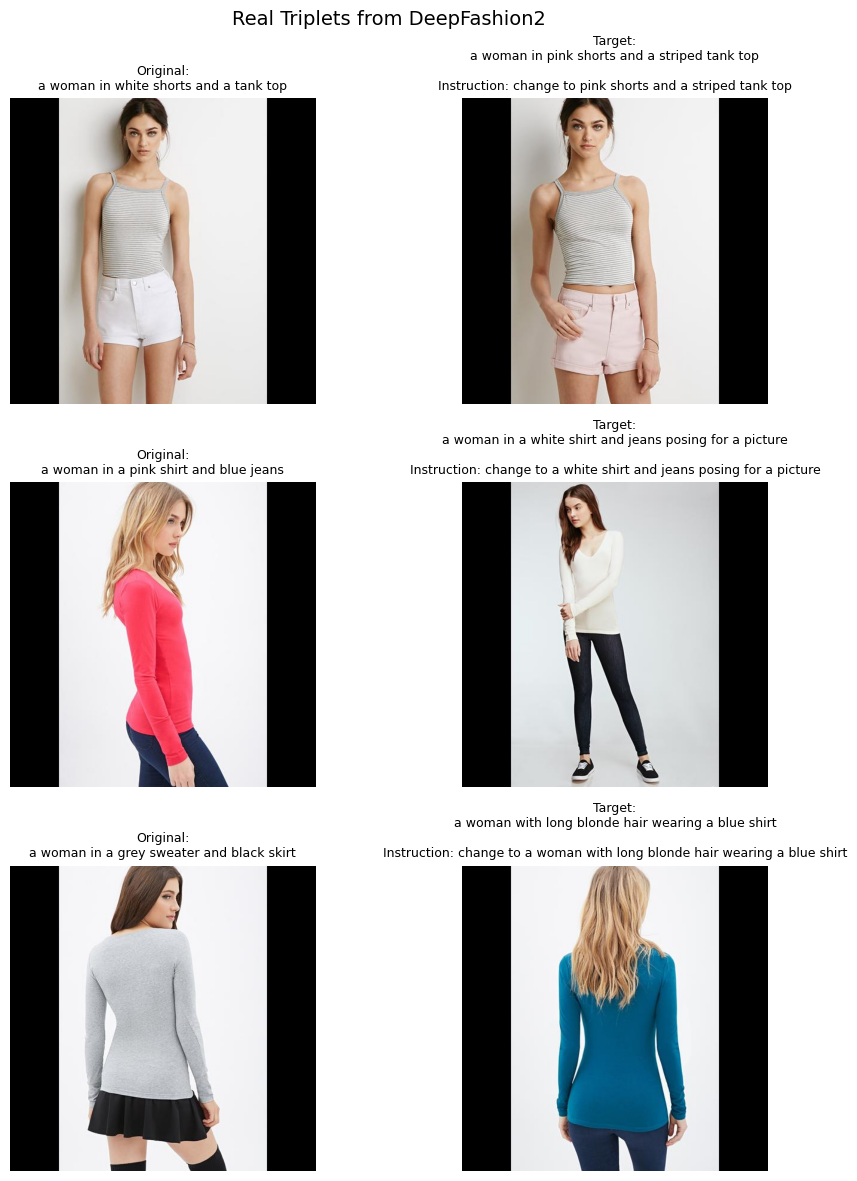

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(10, 12))

for row in range(3):
    t = triplets[row * 100]

    src = dataset["train"][t["src_idx"]]
    tgt = dataset["train"][t["tgt_idx"]]
    instruction = generate_instruction(src["caption"], tgt["caption"])

    axes[row, 0].imshow(src["images"])
    axes[row, 0].set_title(f"Original:\n{src['caption']}", fontsize=9)
    axes[row, 0].axis("off")

    axes[row, 1].imshow(tgt["images"])
    axes[row, 1].set_title(f"Target:\n{tgt['caption']}\n\nInstruction: {instruction}", fontsize=9)
    axes[row, 1].axis("off")

plt.suptitle("Real Triplets from DeepFashion2", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
CACHE_DIR = "deepfashion_cache"
os.makedirs(CACHE_DIR, exist_ok=True)

# get the unique indices we need
all_indices = set()
for t in triplets:
  all_indices.add(t["src_idx"])
  all_indices.add(t["tgt_idx"])

for idx in tqdm(all_indices, desc="caching the images"):
  cache_path = f"{CACHE_DIR}/{idx}.png"
  if not os.path.exists(cache_path):
      img = dataset["train"][idx]["images"]
      img.save(cache_path)


Caching 258 unique images...


Caching images: 100%|██████████| 258/258 [00:03<00:00, 68.09it/s]

Caching complete!


In [ ]:
class TripletDataset(Dataset):
    def __init__(self, triplet_list, hf_data, size=512):
        self.data = triplet_list
        self.hf = hf_data
        self.size = size
        self.transform = transforms.Compose([
            transforms.Resize((size, size), interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])

        self.mask_transform = transforms.Compose([
            transforms.Resize((size, size), interpolation=transforms.InterpolationMode.NEAREST),
            transforms.ToTensor(),
        ])
        self.color_jitter = transforms.ColorJitter(
            brightness=0.1,
            contrast=0.1,
            saturation=0.1,
            hue=0.05,
        )

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        t = self.data[idx]

        src = self.hf["train"][t["src_idx"]]
        tgt = self.hf["train"][t["tgt_idx"]]

        orig_img = src["images"]
        edit_img = tgt["images"]
        instruction = generate_instruction(src["caption"], tgt["caption"])
        src_mask = src["mask"]

        if orig_img.mode != "RGB":
            orig_img = orig_img.convert("RGB")
        if edit_img.mode != "RGB":
            edit_img = edit_img.convert("RGB")
        if src_mask.mode != "L":
          src_mask = src_mask.convert("L")

        if torch.rand(1).item() < 0.5:
            orig_img = TF.hflip(orig_img)
            edit_img = TF.hflip(edit_img)
            src_mask = TF.hflip(src_mask)

        orig_img = self.color_jitter(orig_img)
        edit_img = self.color_jitter(edit_img)

        conditioning_image = self.transform(orig_img)
        pixel_values = self.transform(edit_img)
        mask_tensor = self.mask_transform(src_mask)
        mask_tensor = (mask_tensor > 0.5).float()

        return {
            "conditioning_image": conditioning_image,
            "pixel_values": pixel_values,
            "prompt": instruction,
            "mask": mask_tensor,
        }

full_ds = TripletDataset(triplets, dataset, size=512)

train_size = int(len(full_ds) * 0.8)
val_size = int(len(full_ds) * 0.1)
test_size = len(full_ds) - train_size - val_size

train_ds, val_ds, test_ds = torch.utils.data.random_split(
    full_ds,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

BATCH_SIZE = 1
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")

test_batch = next(iter(train_loader))
print(f"Conditioning shape: {test_batch['conditioning_image'].shape}")
print(f"Sample prompt: {test_batch['prompt'][0]}")

Train: 6400, Val: 800, Test: 800
Conditioning shape: torch.Size([1, 3, 512, 512])
Sample prompt: change to a man wearing a blue shirt and black pants
DataLoader working!


# 3. Model Preparation and Baseline

## 3.1 Calculating Clip Score and Directional Similarity Scores (Evaluation Metrics)


The upcoming code cell now includes a variety of different functions used for metrics.

In [ ]:
#Define evaluation metrics

#clip score, which tells us how similar text is to image.
def calculate_clip_score(image, text, clip_model, clip_processor):
    """Author: David Thai -- function to calculate the clip score."""
    inputs = clip_processor(
        text=[text],
        images=image,
        return_tensors="pt",
        padding=True
    ).to("cuda")
    with torch.no_grad(): #the following is cosine similarity
        outputs = clip_model(**inputs)
        image_embeds = outputs.image_embeds / outputs.image_embeds.norm(dim=-1, keepdim=True)
        text_embeds = outputs.text_embeds / outputs.text_embeds.norm(dim=-1, keepdim=True)
        clip_score = (image_embeds @ text_embeds.T).item()
    return clip_score * 100



#directional simularity
def calculate_clip_directional_similarity(original_img, edited_img, text, clip_model, clip_processor):
   """Author: David Thai -- function to calculate the clip directional similarity"""
    with torch.no_grad():
        #original embeddings
        inputs_orig = clip_processor(images=original_img, return_tensors="pt").to("cuda")
        orig_embeds = clip_model.get_image_features(**inputs_orig)
        orig_embeds = orig_embeds / orig_embeds.norm(dim=-1, keepdim=True)
        #edit embeddings
        inputs_edit = clip_processor(images=edited_img, return_tensors="pt").to("cuda")
        edit_embeds = clip_model.get_image_features(**inputs_edit)
        edit_embeds = edit_embeds / edit_embeds.norm(dim=-1, keepdim=True)
        #text embeddings
        inputs_text = clip_processor(text=[text], return_tensors="pt", padding=True).to("cuda")
        text_embeds = clip_model.get_text_features(**inputs_text)
        text_embeds = text_embeds / text_embeds.norm(dim=-1, keepdim=True)
        #calculate direction
        img_direction = edit_embeds - orig_embeds
        img_direction = img_direction / (img_direction.norm(dim=-1, keepdim=True) + 1e-8)
        #neutral starting point
        null_text = clip_processor(text=[""], return_tensors="pt", padding=True).to("cuda")
        null_embeds = clip_model.get_text_features(**null_text)
        null_embeds = null_embeds / null_embeds.norm(dim=-1, keepdim=True)
        #determine direction
        text_direction = text_embeds - null_embeds
        text_direction = text_direction / (text_direction.norm(dim=-1, keepdim=True) + 1e-8)
        #calculate cosine similarity
        directional_sim = (img_direction @ text_direction.T).item()
    return directional_sim * 100

#LPIPS Score

lpips_model = lpips.LPIPS(net='alex').to("cuda")

lpips_transform = T.Compose([
    T.Resize((512, 512)),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5],
                std=[0.5, 0.5, 0.5]),
])

def calculate_lpips(img1_pil, img2_pil):
    t1 = lpips_transform(img1_pil).unsqueeze(0).to("cuda")
    t2 = lpips_transform(img2_pil).unsqueeze(0).to("cuda")
    with torch.no_grad():
        score = lpips_model(t1, t2).item()
    return score

## 3.2 Evaluate Model

Now we prepare the model and use this baseline for InstructPix2Pix on fashionpedia, just to see how it performs as a baseline.

In [ ]:
# Evaluating a baseline for InstructPix2Pix on fashionpedia

NUM_SAMPLES = 3  # num of images to test
NUM_INFERENCE_STEPS =50   # inference steps -- means lower = faster, higher = better quality
GUIDANCE_SCALE = 7.5
IMAGE_GUIDANCE_SCALE = 1.5

# this is the output directiory where the eval results are saved.
os.makedirs('evaluation_results', exist_ok=True)
os.makedirs('evaluation_results/images', exist_ok=True)

results = []
all_edits = []

for idx in range(3):
    sample = fashionpedia_samples[idx]
    original_image = sample['image']

    prompts = ['change the clothes this person is wearing to blue',
            'make the clothes this person is wearing red',
            'add stripes to the clothes',
            'change the clothes to a floral pattern']

    if max(original_image.size) > 1024:
      original_image.thumbnail((1024, 1024), Image.Resampling.LANCZOS)

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.imshow(original_image)
    ax.set_title(f'Original Image (Sample {idx + 1})', fontsize=14, fontweight='bold')
    ax.axis('off')
    plt.tight_layout()
    plt.show()

    for prompt_idx, text_prompt in enumerate(prompts):
      try:
          edited_images = pipe(
              prompt=text_prompt,
              image=original_image,
              num_inference_steps=NUM_INFERENCE_STEPS,
              guidance_scale=GUIDANCE_SCALE,
              image_guidance_scale=IMAGE_GUIDANCE_SCALE,
          ).images
          edited_image = edited_images[0]

          clip_score_original = calculate_clip_score(original_image, text_prompt, clip_model, clip_processor)
          clip_score_edited = calculate_clip_score(edited_image, text_prompt, clip_model, clip_processor)
          clip_directional = calculate_clip_directional_similarity(
              original_image, edited_image, text_prompt, clip_model, clip_processor
          )

          fig, axes = plt.subplots(1, 2, figsize=(16, 8))

          axes[0].imshow(original_image)
          axes[0].set_title(f'Original CLIP Score: {clip_score_original:.2f}',
                            fontsize=12, fontweight='bold')
          axes[0].axis('off')

          axes[1].imshow(edited_image)
          axes[1].set_title(f'Edited LIP Score: {clip_score_edited:.2f} (Δ: {clip_score_edited - clip_score_original:+.2f})',
                            fontsize=12, fontweight='bold')
          axes[1].axis('off')

          metrics_text = f'Value of directional Similarity: {clip_directional:.2f}'
          plt.figtext(0.5, 0.02, metrics_text, ha='center', fontsize=11, bbox=dict(boxstyle='round', facecolor='hotpink', alpha=0.8))

          plt.suptitle(f'Prompt: "{text_prompt}"', fontsize=13, fontweight='bold', style='italic')
          plt.tight_layout()
          plt.subplots_adjust(bottom=0.08)
          plt.show()

          result = {
              'sample_id': f"{idx}_{prompt_idx}",
              'sample_num': idx + 1,
              'edit_num': prompt_idx + 1,
              'prompt': text_prompt,
              'clip_score_original': clip_score_original,
              'clip_score_edited': clip_score_edited,
              'clip_score_improvement': clip_score_edited - clip_score_original,
              'clip_directional_similarity': clip_directional,
          }
          results.append(result)

          all_edits.append({
              'original': original_image,
              'edited': edited_image,
              'prompt': text_prompt,
              'metrics': result
          })

          print(f"   CLIP Score: {clip_score_edited:.2f} | improvement: {clip_score_edited - clip_score_original:+.2f} | directional Sim: {clip_directional:.2f}")

      except Exception as e:
          print(f"   Error: {e}")
          continue


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
lpips_value = calculate_lpips(original_image, edited_image)
print(f"LPIPS (baseline): {lpips_value:.4f}")

In [ ]:
num_edits = len(all_edits)
if num_edits == 0:
    print("Issue: no edits found in all_edits.")
else:
    prompts_per_sample = 4
    num_samples = num_edits // prompts_per_sample

    fig, axes = plt.subplots(num_samples, prompts_per_sample, figsize=(14, 3 * num_samples))

    if num_samples == 1:
        axes = [axes]

    for idx, edit in enumerate(all_edits):
        row = idx // prompts_per_sample
        col = idx % prompts_per_sample

        ax = axes[row][col]

        orig = edit["original"]
        edited = edit["edited"]

        small_orig = orig.copy()
        small_edit = edited.copy()
        small_orig.thumbnail((256, 256))
        small_edit.thumbnail((256, 256))

        combined = np.hstack((small_orig, small_edit))

        ax.imshow(combined)
        ax.set_title(edit["prompt"], fontsize=9)
        ax.axis("off")

    plt.tight_layout()
    plt.show()


# 4. Fine Tuning

We first start with parameter efficient fine tuning:

In [ ]:
gc.collect()
torch.cuda.empty_cache()

pipe = StableDiffusionInstructPix2PixPipeline.from_pretrained(
    "timbrooks/instruct-pix2pix",
    torch_dtype=torch.float16,
    safety_checker=None,
)
pipe.to("cuda")

pipe.scheduler = DDPMScheduler.from_config(pipe.scheduler.config)

unet = pipe.unet
vae = pipe.vae
tokenizer = pipe.tokenizer
text_encoder = pipe.text_encoder
noise_scheduler = pipe.scheduler
device = "cuda"

for param in unet.parameters():
    param.requires_grad = False

for name, param in unet.named_parameters():
      should_unfreeze = False

      if "attn2" in name and ("to_k" in name or "to_v" in name or "to_out" in name):
          should_unfreeze = True

      if "attn1" in name and ("to_k" in name or "to_v" in name or "to_q" in name):
          should_unfreeze = True

      if "mid_block" in name:
          should_unfreeze = True

      if "up_blocks.2" in name or "up_blocks.3" in name:
          if "resnets" in name and "conv" in name:
              should_unfreeze = True

      if should_unfreeze:
          param.requires_grad = True

trainable_params = [p for p in unet.parameters() if p.requires_grad]

optimizer = AdamW(trainable_params, lr=1e-5, eps=1e-4, weight_decay=0.01)

print(f"Trainable params: {sum(p.numel() for p in trainable_params):,}")
print(f"Total params: {sum(p.numel() for p in unet.parameters()):,}")
print(f"Trainable %: {100 * sum(p.numel() for p in trainable_params) / sum(p.numel() for p in unet.parameters()):.2f}%")
print("\nUnfrozen layers:")
for name, param in unet.named_parameters():
    if param.requires_grad:
        print(f"  {name}: {param.numel():,}")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Trainable params: 204,885,120
Total params: 859,532,484
Trainable %: 23.84%

Unfrozen layers:
  down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_q.weight: 102,400
  down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_k.weight: 102,400
  down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_v.weight: 102,400
  down_blocks.0.attentions.0.transformer_blocks.0.attn2.to_k.weight: 245,760
  down_blocks.0.attentions.0.transformer_blocks.0.attn2.to_v.weight: 245,760
  down_blocks.0.attentions.0.transformer_blocks.0.attn2.to_out.0.weight: 102,400
  down_blocks.0.attentions.0.transformer_blocks.0.attn2.to_out.0.bias: 320
  down_blocks.0.attentions.1.transformer_blocks.0.attn1.to_q.weight: 102,400
  down_blocks.0.attentions.1.transformer_blocks.0.attn1.to_k.weight: 102,400
  down_blocks.0.attentions.1.transformer_blocks.0.attn1.to_v.weight: 102,400
  down_blocks.0.attentions.1.transformer_blocks.0.attn2.to_k.weight: 245,760
  down_blocks.0.attentions.1.transformer_blocks.0.attn2.t

## 4.1 Training Loop for Fine-Tuning

In [ ]:
def encode_prompt(texts):
    tokens = tokenizer(
        list(texts),
        padding="max_length",
        max_length=tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
    ).input_ids.to(device)
    with torch.no_grad():
        text_embeds = text_encoder(tokens)[0]
    return text_embeds

def encode_vae_images(images):
    images = images.to(device, dtype=torch.float16)
    with torch.no_grad():
        latents = vae.encode(images).latent_dist.sample()
    return latents * vae.config.scaling_factor

@torch.no_grad()
def validate(val_loader, num_samples=50):
  unet.eval()

  val_losses = []
  clip_scores = []
  dir_sims = []

  samples_processed = 0

  for batch in val_loader:
      if samples_processed >= num_samples:
          break

      pixel_values = batch["pixel_values"].to(device, dtype=torch.float16)
      cond_images = batch["conditioning_image"].to(device, dtype=torch.float16)
      masks = batch["mask"].to(device, dtype=torch.float16)
      prompts = batch["prompt"]

      target_latents = encode_vae_images(pixel_values)
      cond_latents = encode_vae_images(cond_images)
      mask_latent = F.interpolate(masks, size=target_latents.shape[-2:], mode="nearest")
      mask_latent = mask_latent.expand(-1, 4, -1, -1)

      noise = torch.randn_like(target_latents)
      timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps,
                                  (target_latents.shape[0],), device=device, dtype=torch.long)
      noisy_latents = noise_scheduler.add_noise(target_latents, noise, timesteps)
      model_input = torch.cat([noisy_latents, cond_latents], dim=1)
      text_embeds = encode_prompt(prompts)

      with torch.autocast(device_type="cuda", dtype=torch.float16):
          noise_pred = unet(model_input, timesteps, encoder_hidden_states=text_embeds, return_dict=False)[0]

      M_cloth = mask_latent
      M_bg = 1.0 - mask_latent
      L_cloth = F.mse_loss((noise_pred * M_cloth).float(), (noise * M_cloth).float())
      L_bg = F.mse_loss((noise_pred * M_bg).float(), (noise * M_bg).float())
      loss = L_cloth + LAMBDA_PRESERVE * L_bg
      val_losses.append(loss.item())

      if samples_processed % 5 == 0:
          cond_img_pil = to_pil_image(cond_images[0].cpu().float() * 0.5 + 0.5)

          with torch.autocast("cuda"):
              edited = pipe(
                  prompt=prompts[0],
                  image=cond_img_pil,
                  num_inference_steps=20,
                  guidance_scale=7.5,
                  image_guidance_scale=1.5,
              ).images[0]

          clip_score = calculate_clip_score(edited, prompts[0], clip_model, clip_processor)
          dir_sim = calculate_clip_directional_similarity(cond_img_pil, edited, prompts[0], clip_model, clip_processor)

          clip_scores.append(clip_score)
          dir_sims.append(dir_sim)

      samples_processed += 1

  unet.train()

  return {
      "val_loss": sum(val_losses) / len(val_losses),
      "clip_score": sum(clip_scores) / len(clip_scores) if clip_scores else 0,
      "dir_sim": sum(dir_sims) / len(dir_sims) if dir_sims else 0,
  }


EPOCHS = 4
MAX_GRAD_NORM = 1.0
LAMBDA_PRESERVE = 0.5
PATIENCE = 2

num_training_steps = EPOCHS * len(train_loader)
scheduler = CosineAnnealingLR(optimizer, T_max=num_training_steps)

unet.train()
train_losses = []
val_metrics_history = []
best_val_dirsim = float("-inf")
epochs_no_improve = 0

for epoch in range(EPOCHS):
  epoch_losses = []
  pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")

  for step, batch in enumerate(pbar):
      pixel_values = batch["pixel_values"].to(device, dtype=torch.float16)
      cond_images = batch["conditioning_image"].to(device, dtype=torch.float16)
      masks = batch["mask"].to(device, dtype=torch.float16)
      prompts = batch["prompt"]

      with torch.no_grad():
          target_latents = encode_vae_images(pixel_values)
          cond_latents = encode_vae_images(cond_images)
          mask_latent = F.interpolate(masks, size=target_latents.shape[-2:], mode="nearest")
          mask_latent = mask_latent.expand(-1, 4, -1, -1)

      noise = torch.randn_like(target_latents)
      bsz = target_latents.shape[0]

      timesteps = torch.randint(
          0, noise_scheduler.config.num_train_timesteps,
          (bsz,), device=device, dtype=torch.long
      )

      noisy_latents = noise_scheduler.add_noise(target_latents, noise, timesteps)

      model_input = torch.cat([noisy_latents, cond_latents], dim=1)

      text_embeds = encode_prompt(prompts)

      optimizer.zero_grad()

      with torch.autocast(device_type="cuda", dtype=torch.float16):
          noise_pred = unet(
              model_input,
              timesteps,
              encoder_hidden_states=text_embeds,
              return_dict=False
          )[0]

      # ---------------- Mask-aware loss ----------------
      M_cloth = mask_latent
      M_bg = 1.0 - mask_latent

      L_denoise_cloth = F.mse_loss((noise_pred * M_cloth).float(), (noise * M_cloth).float())
      L_preserve = F.mse_loss((noise_pred * M_bg).float(), (noise * M_bg).float())

      loss = L_denoise_cloth + LAMBDA_PRESERVE * L_preserve

      if not torch.isfinite(loss):
          print(f"Non-finite loss at step {step}, skipping...")
          continue

      loss.backward()
      torch.nn.utils.clip_grad_norm_(trainable_params, MAX_GRAD_NORM)

      has_nan_grad = False
      for p in trainable_params:
          if p.grad is not None and not torch.isfinite(p.grad).all():
              has_nan_grad = True
              break

      if has_nan_grad:
          print(f"Non-finite gradient at step {step}, skipping...")
          optimizer.zero_grad()
          continue

      optimizer.step()
      scheduler.step()

      epoch_losses.append(loss.item())
      pbar.set_postfix({
          "loss": f"{loss.item():.4f}",
          "lr": f"{scheduler.get_last_lr()[0]:.2e}"
      })

  avg_loss = sum(epoch_losses) / len(epoch_losses) if epoch_losses else float('nan')
  train_losses.append(avg_loss)
  print(f"Epoch {epoch+1} average loss: {avg_loss:.4f}")

  print(f"Running validation...")
  val_metrics = validate(val_loader, num_samples=50)
  val_metrics_history.append(val_metrics)

  print(f"  Val Loss: {val_metrics['val_loss']:.4f}")
  print(f"  CLIP Score: {val_metrics['clip_score']:.2f}")
  print(f"  Directional Sim: {val_metrics['dir_sim']:.2f}")

  if val_metrics['dir_sim'] > best_val_dirsim:
      best_val_dirsim = val_metrics['dir_sim']
      epochs_no_improve = 0
      torch.save(unet.state_dict(), "unet_best.pt")
      print(f"  New best model saved! (dir_sim: {best_val_dirsim:.2f})")
  else:
      epochs_no_improve += 1
      print(f"  No improvement for {epochs_no_improve} epoch(s)")

      if epochs_no_improve >= PATIENCE:
          print(f"Early stopping triggered at epoch {epoch+1}")
          break

  torch.save({
      'epoch': epoch,
      'unet_state_dict': unet.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'scheduler_state_dict': scheduler.state_dict(),
      'train_losses': train_losses,
      'val_metrics': val_metrics_history,
  }, f"checkpoint_epoch{epoch+1}.pt")

print(f"best directional similarity: {best_val_dirsim:.2f}")

Epoch 1/4: 100%|██████████| 6400/6400 [59:39<00:00,  1.79it/s, loss=0.0153, lr=1.25e-06]


Epoch 1 average loss: 0.0469
Running validation...


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  Val Loss: 0.0452
  CLIP Score: 24.27
  Directional Sim: 6.86
  New best model saved! (dir_sim: 6.86)


Epoch 2/4: 100%|██████████| 6400/6400 [59:54<00:00,  1.78it/s, loss=0.1276, lr=7.31e-07]


Epoch 2 average loss: 0.0462
Running validation...


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  Val Loss: 0.0492
  CLIP Score: 23.09
  Directional Sim: 5.60
  No improvement for 1 epoch(s)


Epoch 3/4: 100%|██████████| 6400/6400 [59:55<00:00,  1.78it/s, loss=0.1135, lr=2.14e-07]


Epoch 3 average loss: 0.0464
Running validation...


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  Val Loss: 0.0509
  CLIP Score: 23.91
  Directional Sim: 6.84
  No improvement for 2 epoch(s)
Early stopping triggered at epoch 3
Training complete!
Best directional similarity: 6.86


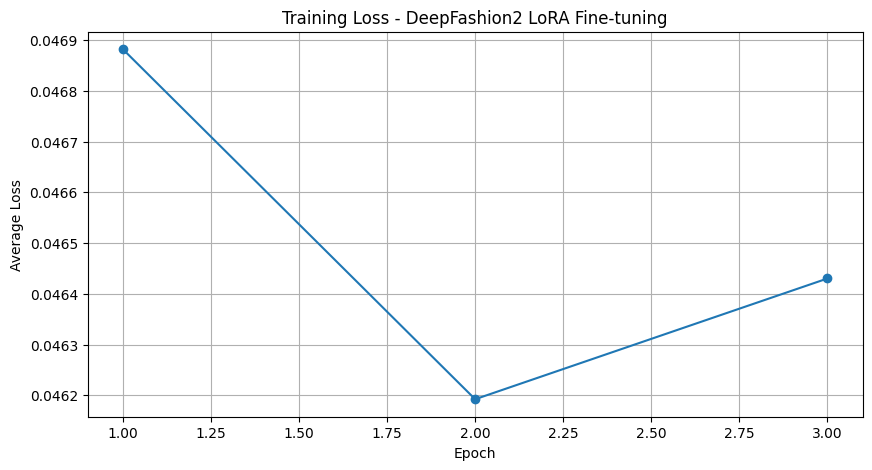

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title(" ")
plt.grid(True)
plt.show()

# 5. Evaluation

In [ ]:
state_dict = torch.load("unet_deepfashion2_epoch3.pt", map_location=device)
unet.load_state_dict(state_dict, strict=False)

pipe.unet = unet
pipe.to("cuda")
pipe.unet.eval()

print("Fine-tuned model loaded!")

Fine-tuned model loaded!


In [ ]:
import torchvision.transforms as T
from pytorch_msssim import ssim as ssim_torch
import lpips



_to_tensor = T.ToTensor()

def pil_to_tensor(image):
    return _to_tensor(image).unsqueeze(0).to(device)

def calculate_ssim(img1_pil, img2_pil):
    x = pil_to_tensor(img1_pil)
    y = pil_to_tensor(img2_pil)
    return ssim_torch(x, y, data_range=1.0, size_average=True).item()

lpips_model = lpips.LPIPS(net='vgg').to(device)
lpips_model.eval()

def calculate_lpips(img1_pil, img2_pil):
    x = 2 * pil_to_tensor(img1_pil) - 1.0
    y = 2 * pil_to_tensor(img2_pil) - 1.0
    with torch.no_grad():
        d = lpips_model(x, y).item()
    return d

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/vgg.pth


In [ ]:
custom_prompts = [
    "change to a floral pattern",
    "make the shirt red",
    "add stripes to the clothes",
    "change shirt to blue",
]

NUM_TEST_IMAGES = 5

fig, axes = plt.subplots(NUM_TEST_IMAGES, len(custom_prompts) + 1, figsize=(18, 4 * NUM_TEST_IMAGES))

custom_results = []

for row in range(NUM_TEST_IMAGES):
    actual_idx = test_ds.indices[row]
    t = triplets[actual_idx]
    src = dataset["train"][t["src_idx"]]
    original_image = src["images"]

    if max(original_image.size) > 512:
        original_image = original_image.copy()
        original_image.thumbnail((512, 512), Image.Resampling.LANCZOS)

    axes[row, 0].imshow(original_image)
    axes[row, 0].set_title("Original" if row == 0 else "")
    axes[row, 0].axis("off")

    for col, prompt in enumerate(custom_prompts):
        with torch.autocast("cuda"):
            edited = pipe(
                prompt=prompt,
                image=original_image,
                num_inference_steps=50,
                guidance_scale=7.5,
                image_guidance_scale=1.5,
            ).images[0]

        clip_score = calculate_clip_score(edited, prompt, clip_model, clip_processor)
        clip_directional = calculate_clip_directional_similarity(
            original_image, edited, prompt, clip_model, clip_processor
        )
        lpips_val = calculate_lpips(original_image, edited)

        custom_results.append({
            'image': row,
            'prompt': prompt,
            'clip_score': clip_score,
            'directional_similarity': clip_directional,
            'lpips': lpips_val,
        })

        axes[row, col + 1].imshow(edited)
        axes[row, col + 1].set_title(prompt if row == 0 else "", fontsize=9)
        axes[row, col + 1].axis("off")

plt.tight_layout()
plt.savefig("custom_prompts_deepfashion2.png", dpi=150, bbox_inches='tight')
plt.show()

# Summary
df_custom = pd.DataFrame(custom_results)
print("\n Custom Prompts Evaluation ===")
print(f"mean CLIP Score: {df_custom['clip_score'].mean():.2f}")
print(f"mean Directional Similarity: {df_custom['directional_similarity'].mean():.2f}")
print(f"mean LPIPS: {df_custom['lpips'].mean():.4f}")
print("\nPer-prompt averages:")
print(df_custom.groupby('prompt')[['clip_score', 'directional_similarity']].mean())

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# compare baseline vs fine tuned
print("Comparison (DeepFashion2)")
print(f"Baseline Mean CLIP Score: {pd.DataFrame(results)['clip_score_edited'].mean():.2f}")
print(f"Fine-tuned Mean CLIP Score: {df_custom['clip_score'].mean():.2f}")
print(f"\nBaseline Mean Directional Sim: {pd.DataFrame(results)['clip_directional_similarity'].mean():.2f}")
print(f"Fine-tuned Mean Directional Sim: {df_custom['directional_similarity'].mean():.2f}")
print(f"Fine-tuned Mean LPIPS: {df_custom['lpips'].mean():.4f}")

=== Comparison (DeepFashion2) ===
Baseline Mean CLIP Score: 22.81
Fine-tuned Mean CLIP Score: 22.25

Baseline Mean Directional Sim: 6.98
Fine-tuned Mean Directional Sim: 10.98
Fine-tuned Mean LPIPS: 0.3901


In [ ]:
def match_size(img1, img2):
    return img2.resize(img1.size, Image.Resampling.LANCZOS)

test_prompts = [
    "change to a floral pattern",
    "make the shirt red",
    "add stripes to the clothes",
    "change shirt to blue",
]

NUM_SAMPLES = 5

finetuned_fashionpedia_results = []

for idx in range(NUM_SAMPLES):
    sample = fashionpedia_samples[idx]
    original_image = sample['image']

    if max(original_image.size) > 512:
        original_image = original_image.copy()
        original_image.thumbnail((512, 512), Image.Resampling.LANCZOS)

    for prompt in test_prompts:
        with torch.autocast("cuda"):
            edited = pipe(
                prompt=prompt,
                image=original_image,
                num_inference_steps=50,
                guidance_scale=7.5,
                image_guidance_scale=1.5,
            ).images[0]

        clip_score = calculate_clip_score(edited, prompt, clip_model, clip_processor)
        clip_directional = calculate_clip_directional_similarity(
            original_image, edited, prompt, clip_model, clip_processor
        )

        edited_resized = match_size(original_image, edited)


        lpips_val = calculate_lpips(original_image, edited_resized)

        finetuned_fashionpedia_results.append({
            'sample': idx,
            'prompt': prompt,
            'clip_score': clip_score,
            'directional_similarity': clip_directional,
            'lpips': lpips_val,
        })

df_finetuned_fp = pd.DataFrame(finetuned_fashionpedia_results)

print("Fine-tuned Model on FashionPedia")
print(f"Mean CLIP Score: {df_finetuned_fp['clip_score'].mean():.2f}")
print(f"Mean Directional Similarity: {df_finetuned_fp['directional_similarity'].mean():.2f}")
print(f"Mean LPIPS: {df_finetuned_fp['lpips'].mean():.4f}")

# Compare with baseline on FashionPedia
print("\nComparison on FashionPedia")
print(f"Baseline Mean CLIP Score: {pd.DataFrame(results)['clip_score_edited'].mean():.2f}")
print(f"Fine-tuned Mean CLIP Score: {df_finetuned_fp['clip_score'].mean():.2f}")
print(f"\nBaseline Mean Directional Sim: {pd.DataFrame(results)['clip_directional_similarity'].mean():.2f}")
print(f"Fine-tuned Mean Directional Sim: {df_finetuned_fp['directional_similarity'].mean():.2f}")
print(f"Fine-tuned Mean LPIPS: {df_finetuned_fp['lpips'].mean():.4f}")

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

=== Fine-tuned Model on FashionPedia ===
Mean CLIP Score: 18.59
Mean Directional Similarity: 10.52
Mean LPIPS: 0.2882

=== Comparison on FashionPedia ===
Baseline Mean CLIP Score: 22.81
Fine-tuned Mean CLIP Score: 18.59

Baseline Mean Directional Sim: 6.98
Fine-tuned Mean Directional Sim: 10.52
Fine-tuned Mean LPIPS: 0.2882


In [ ]:
fig, axes = plt.subplots(NUM_SAMPLES, len(test_prompts) + 1, figsize=(18, 4 * NUM_SAMPLES))

for row in range(NUM_SAMPLES):
    sample = fashionpedia_samples[row]
    original_image = sample['image']

    if max(original_image.size) > 512:
        original_image = original_image.copy()
        original_image.thumbnail((512, 512), Image.Resampling.LANCZOS)

    axes[row, 0].imshow(original_image)
    axes[row, 0].set_title("Original" if row == 0 else "")
    axes[row, 0].axis("off")

    for col, prompt in enumerate(test_prompts):
        with torch.autocast("cuda"):
            edited = pipe(
                prompt=prompt,
                image=original_image,
                num_inference_steps=50,
                guidance_scale=7.5,
                image_guidance_scale=1.5,
            ).images[0]

        axes[row, col + 1].imshow(edited)
        axes[row, col + 1].set_title(prompt if row == 0 else "", fontsize=9)
        axes[row, col + 1].axis("off")

plt.suptitle("fine-tuned Model on FashionPedia (unseen data)", fontsize=14)
plt.tight_layout()
plt.savefig("finetuned_on_fashionpedia.png", dpi=150, bbox_inches='tight')
plt.show()

Output hidden; open in https://colab.research.google.com to view.